CSC380 Final Project - Decision Tree Model

Kieran Chafin, Shale Van Cleve

In [21]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os # `os.path.exists`
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# interactive plot
%matplotlib widget

Part 1: Loading in the Data

In [22]:
def load_data(filename, data_dir="data"):
    # Verify file exists
    filepath = os.path.join("..", data_dir, filename) # Contruct full filepath

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Dataset file {filepath} not found")
    
    # Read just the header line
    with open(filepath, 'r') as f:
        header = f.readline().strip().replace('"', '')  # Remove quotes if present
    
    # Split header and find which column contains 'Class' (case-insensitive)
    header_cols = [col.strip().lower() for col in header.split(',')]
    try:
        label_idx = header_cols.index('class')
    except ValueError:
        raise ValueError("No 'Class' column found in header")
    
    # Load all data (skipping header)
    data = np.loadtxt(filepath, delimiter=',', skiprows=1)
    
    # Separate features and labels
    y = data[:, label_idx].astype(int)  # Label column
    X = np.delete(data, label_idx, axis=1)  # All other columns
    
    return X, y

def calculate_gini(y_left, y_right):
    # Calculate weighted Gini impurity
    n_left, n_right = len(y_left), len(y_right)
    n_total = n_left + n_right
    
    def _gini(y):
        if len(y) == 0: return 0
        counts = np.bincount(y)
        probs = counts / len(y)
        return 1 - np.sum(probs**2)
    
    return (n_left/n_total)*_gini(y_left) + (n_right/n_total)*_gini(y_right)

In [23]:
# Core Functions
class TreeNode:
    def __init__(self, is_leaf=False, class_label=None, svm_model=None):
        self.is_leaf = is_leaf
        self.class_label = class_label
        self.svm_model = svm_model
        self.left = None
        self.right = None

def predict(node, x):
    while not node.is_leaf:
        side = node.svm_model.predict([x])[0]
        node = node.right if side == 1 else node.left
    return node.class_label

def build_tree(X, y, depth=0, max_depth=None, kernel='linear'):
    classes = np.unique(y)

    # Initialize max_depth if not set
    if max_depth is None:
        max_depth = len(classes) - 1
        
    if len(y) <= 0:
        return TreeNode(is_leaf=True, class_label=-1)  # or choose a default

    # Stopping conditions
    if depth >= max_depth or len(classes) == 1 or len(X) < 2:
        majority_class = np.argmax(np.bincount(y))
        return TreeNode(is_leaf=True, class_label=majority_class)

    best_gini = float('inf')
    best_svm, best_mask = None, None

    # Try splitting with one-vs-rest SVM for each class
    for c in classes:
        y_binary = (y == c).astype(int)
        if len(np.unique(y_binary)) < 2:
            continue

        svm = SVC(kernel=kernel).fit(X, y_binary)
        mask = svm.predict(X) == 1  # "rest" vs "target" split
        gini = calculate_gini(y[mask], y[~mask])

        if gini < best_gini:
            best_gini = gini
            best_svm = svm
            best_mask = mask
        print(f"Depth {depth}: Splitting {len(X)} points into {len(y[best_mask])}/{len(y[~best_mask])} (Gini: {best_gini:.3f})")

    # If no split found, make leaf with majority class
    if best_svm is None:
        majority_class = np.argmax(np.bincount(y))
        return TreeNode(is_leaf=True, class_label=majority_class)

    # Create node and recurse
    node = TreeNode(svm_model=best_svm)
    node.right = build_tree(X[best_mask], y[best_mask], depth+1, max_depth, kernel)
    node.left = build_tree(X[~best_mask], y[~best_mask], depth+1, max_depth, kernel)
    return node


def visualize_tree(tree, X_original, y, scaler, title="Decision Boundaries"):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    
    # Use original (unscaled) X for plotting
    x_min, x_max = X_original[:, 0].min() - 0.5, X_original[:, 0].max() + 0.5
    y_min, y_max = X_original[:, 1].min() - 0.5, X_original[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Scale grid points for prediction
    grid_scaled = scaler.transform(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array([predict(tree, point) for point in grid_scaled])
    Z = Z.reshape(xx.shape)
    
    # Plot decision surface and data (unscaled)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    ax.scatter(X_original[:, 0], X_original[:, 1], c=y, cmap='viridis', edgecolor='k')
    ax.set_title(title)
    plt.show()

Depth 0: Splitting 472 points into 127/345 (Gini: 0.481)
Depth 0: Splitting 472 points into 127/345 (Gini: 0.481)
Depth 0: Splitting 472 points into 127/345 (Gini: 0.481)
Depth 0: Splitting 472 points into 130/342 (Gini: 0.477)
Depth 1: Splitting 342 points into 127/215 (Gini: 0.304)
Depth 1: Splitting 342 points into 127/215 (Gini: 0.304)
Depth 1: Splitting 342 points into 127/215 (Gini: 0.304)
Depth 2: Splitting 215 points into 127/88 (Gini: 0.000)
Depth 2: Splitting 215 points into 127/88 (Gini: 0.000)


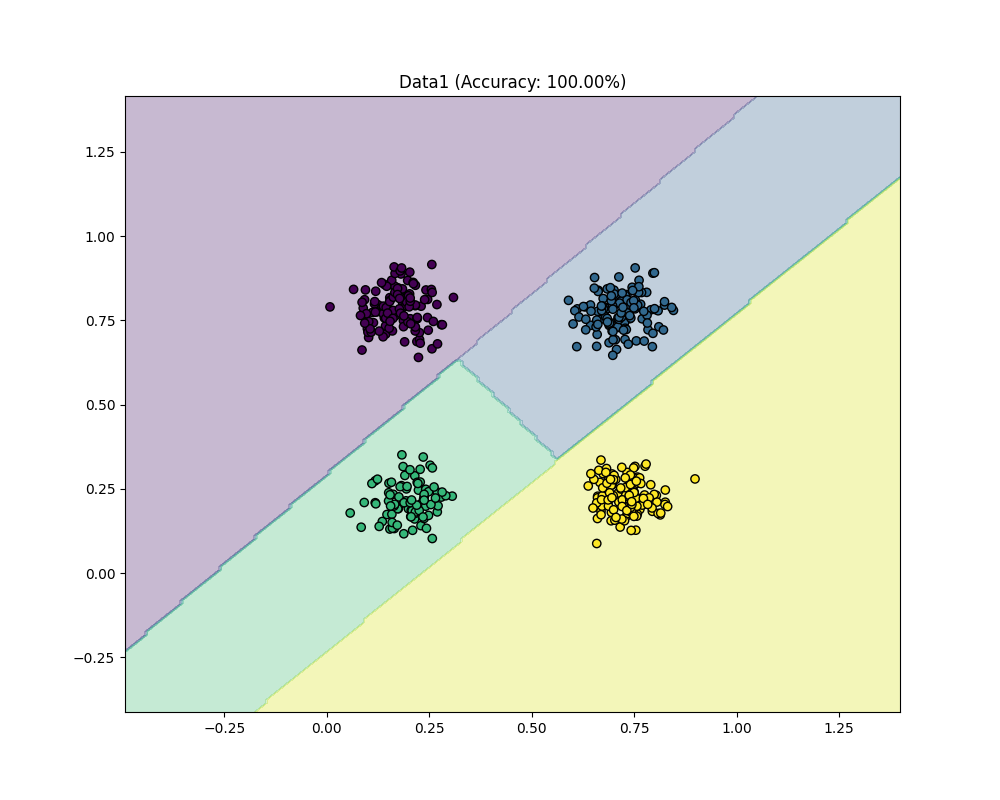


Data1 - Train vs. Test overlap:
Unique train points: 472
Unique test points: 77
Depth 0: Splitting 304 points into 80/224 (Gini: 0.491)
Depth 0: Splitting 304 points into 80/224 (Gini: 0.491)
Depth 0: Splitting 304 points into 80/224 (Gini: 0.491)
Depth 0: Splitting 304 points into 80/224 (Gini: 0.491)
Depth 1: Splitting 224 points into 76/148 (Gini: 0.329)
Depth 1: Splitting 224 points into 76/148 (Gini: 0.329)
Depth 1: Splitting 224 points into 78/146 (Gini: 0.325)
Depth 2: Splitting 146 points into 76/70 (Gini: 0.000)
Depth 2: Splitting 146 points into 76/70 (Gini: 0.000)


/var/folders/jv/pjs6w1js0v9bdj9k1lv10vw40000gn/T/ipykernel_94142/2091639717.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


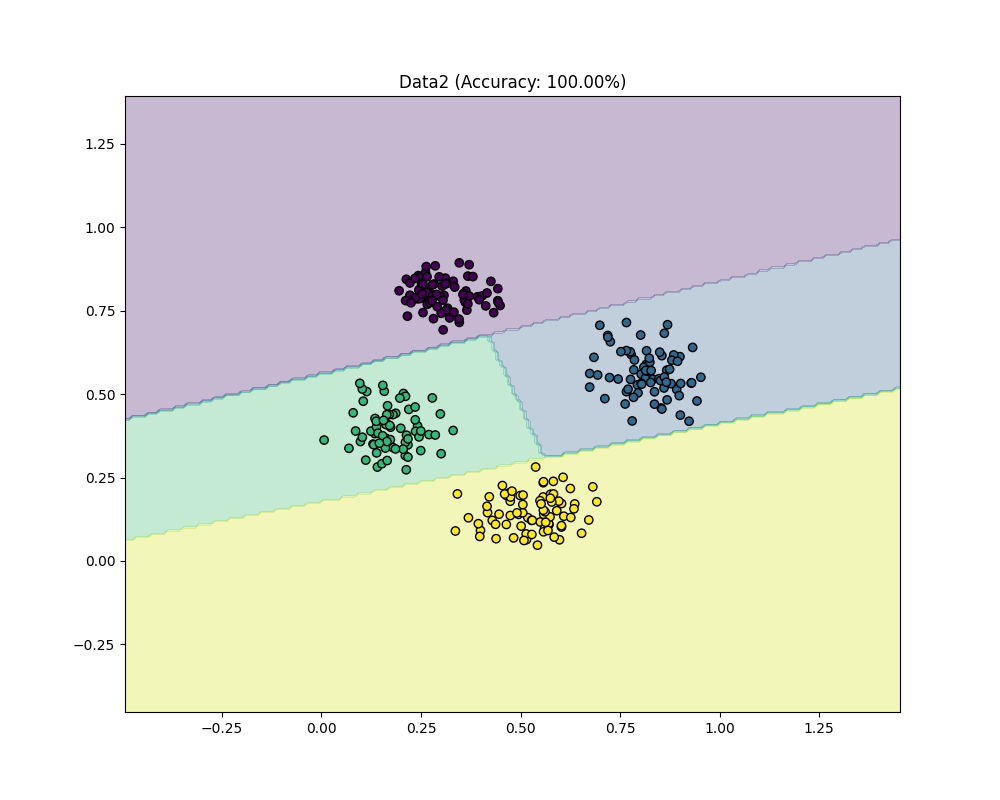


Data2 - Train vs. Test overlap:
Unique train points: 304
Unique test points: 100
Depth 0: Splitting 300 points into 97/203 (Gini: 0.480)
Depth 0: Splitting 300 points into 97/203 (Gini: 0.480)
Depth 0: Splitting 300 points into 97/203 (Gini: 0.480)
Depth 1: Splitting 97 points into 88/9 (Gini: 0.133)
Depth 1: Splitting 97 points into 88/9 (Gini: 0.133)
Depth 1: Splitting 203 points into 0/203 (Gini: 0.577)
Depth 1: Splitting 203 points into 102/101 (Gini: 0.292)
Depth 1: Splitting 203 points into 88/115 (Gini: 0.194)


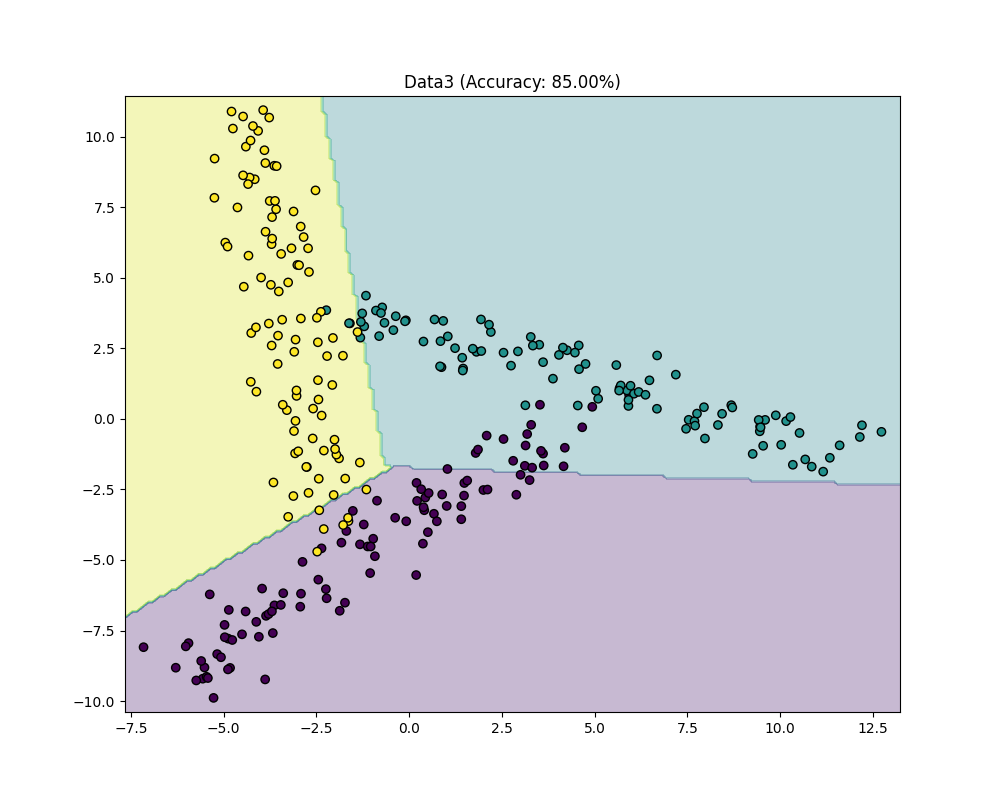


Data3 - Train vs. Test overlap:
Unique train points: 300
Unique test points: 60

Results:
Data1: Accuracy = 100.00%
Data2: Accuracy = 100.00%
Data3: Accuracy = 85.00%


In [26]:
# Main Execution


# we need to print only the test points, currently it is printing both the test and the train points on the plots.
def main():
    datasets = ['Data1', 'Data2', 'Data3']
    results = []
    
    for ds in datasets:
        X_train, y_train = load_data(f"{ds}Train.csv", data_dir="data")
        X_test, y_test = load_data(f"{ds}Test.csv", data_dir="data")
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        kernel = 'rbf' if ds.lower() == 'data4' else 'linear'
        num_classes = len(np.unique(y_train))
        max_depth = num_classes - 1
        
        tree = build_tree(X_train_scaled, y_train, max_depth=max_depth, kernel=kernel)
        y_pred = [predict(tree, x) for x in X_test_scaled]
        acc = accuracy_score(y_test, y_pred)
        results.append((ds, acc))
        
        if ds.lower() != 'data4':
            visualize_tree(tree, X_train, y_train, scaler,  # Pass original X and scaler
                          title=f"{ds} (Accuracy: {acc:.2%})")
    
    print("\nResults:")
    for ds, acc in results:
        print(f"{ds}: Accuracy = {acc:.2%}")

    print(f"\n{ds} - Train vs. Test overlap:")
    print("Unique train points:", len(np.unique(X_train, axis=0)))
    print("Unique test points:", len(np.unique(X_test, axis=0)))

if __name__ == "__main__":
    main()